# Melanoma_Detection_Assignment 


**Problem statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis. Build a multiclass classification model using a custom convolutional neural network in TensorFlow. 

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion Vascular lesion

## Solution Plan:

- Data Reading/Data Understanding
- Dataset Creation
- Dataset visualisation
- Model Building & training
- Chose an appropriate data augmentation strategy to resolve underfitting/overfitting
- Model Building & training on the augmented data
- Class distribution
- Handling class imbalances: with Augmentor[https://augmentor.readthedocs.io/en/master/] library.
- Model Building & training on the rectified class imbalance data


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.regularizers import l2

model = models.Sequential

import os
import PIL

import pathlib
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import Data and Pre-process it

In [2]:
batch_size = 32
epochs = 20
input_image_height = 180
input_image_width = 180

training_data_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
testing_data_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

In [3]:
data_dir_train = pathlib.Path(training_data_dir)
data_dir_test  = pathlib.Path(testing_data_dir)

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Total images in training directory:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Total images in testing directory:", image_count_test)

Total images in training directory: 2239
Total images in testing directory: 118


In [4]:
#?tf.keras.preprocessing.image_dataset_from_directory

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=123,
    validation_split=0.2,
    subset='training',
    label_mode='categorical',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=123,
    validation_split=0.2,
    subset='validation',
    label_mode='categorical',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [6]:
#print('Image per batch:', len(list(train_ds.as_numpy_iterator())))
print('Images in Train:', len(train_ds.file_paths))
print('Images in Validation:', len(val_ds.file_paths))

Images in Train: 1792
Images in Validation: 447


In [7]:
class_names = train_ds.class_names
print('The Class Names are: ', class_names)

The Class Names are:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 2. Visualization of Data

In [ ]:
i = 0
fig = plt.figure(figsize=(9,9))
for ind in range(len(class_names)):
    for img, lab in train_ds:
        #print(np.argmax(lab, axis=1)[0])
        if(np.argmax(lab, axis=1)[0] == ind):
            image = img
            break
    i = i + 1
    ax = plt.subplot(3, 3, i)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[ind])
    plt.axis('off')

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Create the model

**Creating a Sequential model with multiple layers**

In [86]:
model = keras.Sequential()
model.add(keras.layers.Rescaling(1./255, input_shape=(input_image_height, input_image_width, 3)))
model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))

#Convolution with 32 filters
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
#model.add(BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
#model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
#model.add(BatchNormalization())
#model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
#model.add(Dropout(0.25))


##Convolution with 64 filters
#model.add(layers.Conv2D(64, (3,3), padding='same'))
#model.add(Activation('relu'))
##model.add(BatchNormalization())
#model.add(layers.Conv2D(64, (3,3)))
#model.add(Activation('relu'))
##model.add(BatchNormalization())
#model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
##model.add(Dropout(0.25))
#
#
##Convolution with 128 filters
#model.add(layers.Conv2D(128, (3,3), padding='same'))
#model.add(Activation('relu'))
##model.add(BatchNormalization())
#model.add(layers.Conv2D(128, (3,3), padding='same'))
#model.add(Activation('relu'))
##model.add(BatchNormalization())
#model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
##model.add(Dropout(0.25))


model.add(Flatten())
#model.add(Dense(128, kernel_regularizer=l2(0.01)))
#model.add(Dense(128))
#model.add(Activation('relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))

In [87]:
model.build(train_ds.as_numpy_iterator().next()[0].shape)

In [88]:
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 conv2d_42 (Conv2D)          (None, 180, 180, 32)      4640      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 179, 179, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 179, 179, 32)      9248      
                                                                 
 conv2d_44 (Conv2D)          (None, 179, 179, 64)      18496     
                                                     

In [89]:
### Todo, choose an appropirate optimiser and loss function
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, weight_decay=1e-6)
model.compile(optimizer=optimizer, #'sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [90]:
def visualize_outputs(fit_data):
    acc = fit_data.history['accuracy']
    val_acc = fit_data.history['val_accuracy']

    loss = fit_data.history['loss']
    val_loss = fit_data.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [91]:
hist = model.fit(train_ds, epochs = epochs, validation_data=val_ds)

Epoch 1/20
56/56 [==============================] - 191s 3s/step - loss: 2.0653 - accuracy: 0.2015 - val_loss: 2.0367 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 191s 3s/step - loss: 2.0622 - accuracy: 0.2031 - val_loss: 2.0453 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 213s 4s/step - loss: 2.0421 - accuracy: 0.1914 - val_loss: 2.0276 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 189s 3s/step - loss: 2.0286 - accuracy: 0.1948 - val_loss: 2.0239 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 189s 3s/step - loss: 2.0164 - accuracy: 0.1953 - val_loss: 2.0238 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 201s 4s/step - loss: 2.0155 - accuracy: 0.2065 - val_loss: 2.0231 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 182s 3s/step - loss: 2.0158 - accuracy: 0.1987 - val_loss: 2.0246 - val_accuracy: 0.2058
Epoch 8/20
56

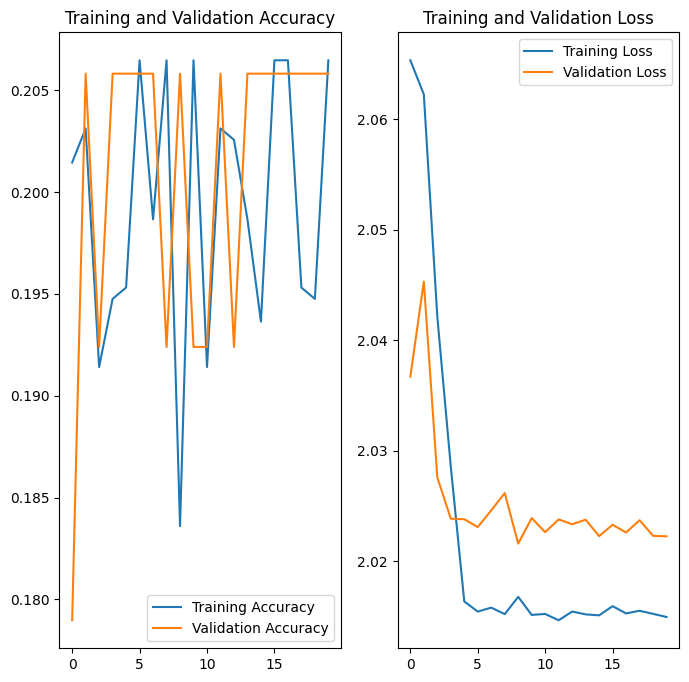

In [92]:
visualize_outputs(hist)

#### Observations

- The training accuracy is not high enough. This can be due to less amount of data to learn. To increase the training samples, we will augment the data.
- Augmentation tries to randomly flip/rotate/zoom the images and add them as new images.
- These can help model learn better...

### Handle Overfitting by using Augmentation

- RandomFlip,
- RandomRotation,
- RandomZoom

In [93]:
!pip install Augmentor
import Augmentor

In [ ]:
augmentor = Augmentor.Pipeline(training_data_dir)
augmentor.flip_random(probability=0.39)
augmentor.skew(probability=0.17)
augmentor.greyscale(probability=0.05)
augmentor.zoom_random(probability=0.17, percentage_area=0.11)
augmentor.random_distortion(probability=0.31, grid_width=input_image_width, grid_height=input_image_height, magnitude=1)
augmentor.rotate(probability=0.13, max_left_rotation=10, max_right_rotation=12)

augmentor.sample(500)

In [100]:
image_count_train = len(list(data_dir_train.glob('output/*/*.jpg')))
print(image_count_train)

500


In [105]:
path_list_new = list(data_dir_train.glob('output/*/*.jpg'))
print("Newly Generated Images Count:", len(path_list_new))

path_list_old = list(data_dir_train.glob('*/*.jpg'))
print("Existing Images Count:", len(path_list_old))

Newly Generated Images Count: 500
Existing Images Count: 2239


In [108]:
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in path_list_new]
print("Categories of Newly Generated Images:", set(lesion_list_new))

lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in path_list_old]
print("Categories of Existing Generated Images:", set(lesion_list_old))

Categories of Newly Generated Images: {'vascular lesion', 'basal cell carcinoma', 'pigmented benign keratosis', 'actinic keratosis', 'nevus', 'seborrheic keratosis', 'melanoma', 'squamous cell carcinoma', 'dermatofibroma'}
Categories of Existing Generated Images: {'vascular lesion', 'basal cell carcinoma', 'pigmented benign keratosis', 'actinic keratosis', 'nevus', 'seborrheic keratosis', 'melanoma', 'squamous cell carcinoma', 'dermatofibroma'}


2239

In [109]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))

In [119]:
df_new = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df_old = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])consolidated_dff =pd.concat([df_new, df_old])

In [118]:
consolidated_df['Label'].value_counts()

NameError: name 'consolidated_df' is not defined

In [ ]:
k = train_ds.concatenate(val_ds)

In [ ]:
print('Images in Train:', len(k.file_paths))

augmenter_model = layers.experimental.preprocessing.PreprocessingLayer()
augmenter_model.add(layers.experimentatal.preprocessing.RandomContrast('horizontal', input_shape=(input_image_height, input_image_width, 3) ))
augmenter_model.add(layers.experimentatal.preprocessing.RandomTranslation( 0.2, 0.2, fill_mode="nearest",  seed = 123))
augmenter_model.add(layers.experimentatal.preprocessing.RandomFlip(mode=HORIZONTAL_AND_VERTICAL, seed=123 ))
augmenter_model.add(layers.experimentatal.preprocessing.RandomZoom( 0.2, 0.3, fill_mode="nearest", seed=123 ))

In [ ]:
#fig = plt.figure(figsize=(9,9))
#
#for each_class in range(len(class_names)):
#    fig_path = [x for x in train_ds.file_paths if x.startswith("{0}{1}".format(training_data_dir, class_names[each_class]))][0]
#    #print(fig_path)
#    ax = plt.subplot(3, 3, each_class+1)
#
#    plt.imshow(cv2.imread(fig_path))
#    plt.title(class_names[each_class])
#    plt.axis("off")
#plt.show()

In [ ]:
#class_names = train_ds.class_names
#fig = plt.figure(figsize=(8,3))
#
#for i in range(len(class_names)):
#    ax = fig.add_subplot(2,5,1+i, xticks=[], yticks=[])
#    im = train_ds[i]
#    plt.imshow(im)
#plt.show()

In [ ]:
#?train_ds.take

In [ ]:
#?train_ds.as_numpy_iterator

In [ ]:
#?tf.keras.utils.image_dataset_from_directory

In [ ]:
#[[x for x in train_ds.file_paths if x.startswith("{0}{1}".format(training_data_dir, c))][0] for c in class_names]

In [ ]:
#for images, labels in train_ds.map(lambda x, y: (x, y)):
#    #for l in labels:
#    #    print(l)
#    conc_labels = labels[0]+labels[1]
#    numpy_data = conc_labels.numpy()
#    if(numpy_data == 1):
#        print(numpy_data)
#    #print(conc_labels.lambda(x: x.numpy()==1))
#    #numpy_data.numpy()

In [ ]:
#train_ds.map(lambda x, y: (x, y)).list_files()

In [ ]:
#?train_ds.map #.get_single_element

In [ ]:
#plt.figure(figsize = (10,10))
#for images, labels in train_ds.take(1):
#    for i in range(9):
#        ax = plt.subplot(3,3,i+1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

In [ ]:
#?train_ds.take

In [ ]:
tf.compat.v1.data.experimental.get_single_element(train_ds)

In [ ]:
#[[x for x in train_ds.file_paths if x.startswith("{0}{1}".format(training_data_dir, c))][0] for c in class_names]

In [ ]:
train_ds.as_numpy_iterator().next()[0].shape